In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import matplotlib.patches as mpatches

In [40]:
trader_data_path = 'historical_data.csv'
sentiment_data_path = 'fear_greed_index.csv'

    
trader_df = pd.read_csv(trader_data_path)
print("✅ Successfully loaded Historical Trader Data. Here are the first 5 rows:")
print(trader_df.head())

sentiment_df = pd.read_csv(sentiment_data_path)
print("✅ Successfully loaded Fear & Greed Index Data. Here are the first 5 rows:")
print(sentiment_df.head())

✅ Successfully loaded Historical Trader Data. Here are the first 5 rows:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                  

In [41]:
sentiment_df.columns = sentiment_df.columns.str.lower().str.replace(' ', '_')
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

In [42]:
trader_df.columns = trader_df.columns.str.lower().str.replace(' ', '_')

trader_df['time'] = pd.to_datetime(trader_df['timestamp'], unit='ms')

trader_df['date'] = trader_df['time'].dt.date
trader_df['date'] = pd.to_datetime(trader_df['date'])

numeric_cols = ['execution_price', 'size_usd', 'closed_pnl']
for col in numeric_cols:
    if col in trader_df.columns:
        trader_df[col] = pd.to_numeric(trader_df[col], errors='coerce')

trader_df.info()
print(trader_df[['time', 'date', 'size_usd', 'closed_pnl']].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   account           211224 non-null  object        
 1   coin              211224 non-null  object        
 2   execution_price   211224 non-null  float64       
 3   size_tokens       211224 non-null  float64       
 4   size_usd          211224 non-null  float64       
 5   side              211224 non-null  object        
 6   timestamp_ist     211224 non-null  object        
 7   start_position    211224 non-null  float64       
 8   direction         211224 non-null  object        
 9   closed_pnl        211224 non-null  float64       
 10  transaction_hash  211224 non-null  object        
 11  order_id          211224 non-null  int64         
 12  crossed           211224 non-null  bool          
 13  fee               211224 non-null  float64       
 14  trad

In [43]:
daily_summary_df = trader_df.groupby('date').agg(
    total_volume=('size_usd', 'sum'),
    net_pnl=('closed_pnl', 'sum'),
    trade_count=('size_usd', 'count'),
    unique_traders=('account', 'nunique')
).reset_index()

print(daily_summary_df.head())

print(daily_summary_df.describe())

daily_summary_df.info()

        date  total_volume       net_pnl  trade_count  unique_traders
0 2023-03-28  4.770000e+02  0.000000e+00            3               1
1 2023-11-14  1.155543e+07  1.555034e+02         1045               2
2 2024-03-09  3.940677e+07  1.769655e+05         6962               5
3 2024-07-03  2.184323e+07  1.587424e+05         7141               8
4 2024-10-27  1.039478e+08  3.189461e+06        35241              29
                                date  total_volume       net_pnl  \
count                              7  7.000000e+00  7.000000e+00   
mean   2024-06-16 06:51:25.714285824  1.701696e+08  1.470994e+06   
min              2023-03-28 00:00:00  4.770000e+02  0.000000e+00   
25%              2024-01-11 00:00:00  1.669933e+07  3.593243e+04   
50%              2024-07-03 00:00:00  3.940677e+07  1.587424e+05   
75%              2024-12-23 12:00:00  2.071115e+08  1.683213e+06   
max              2025-06-15 00:00:00  7.041585e+08  6.699925e+06   
std                              NaN

In [44]:
merged_df = pd.merge(daily_summary_df, sentiment_df, on='date', how='inner')

def map_sentiment(value):
    if 'Fear' in value:
        return 'Fear'
    elif 'Greed' in value:
        return 'Greed'
    else:
        return 'Neutral'

merged_df['classification'] = merged_df['classification'].apply(map_sentiment)
merged_df = merged_df[merged_df['classification'] != 'Neutral']

print(f"Final categories are: {merged_df['classification'].unique()}")

Final categories are: ['Greed' 'Fear']


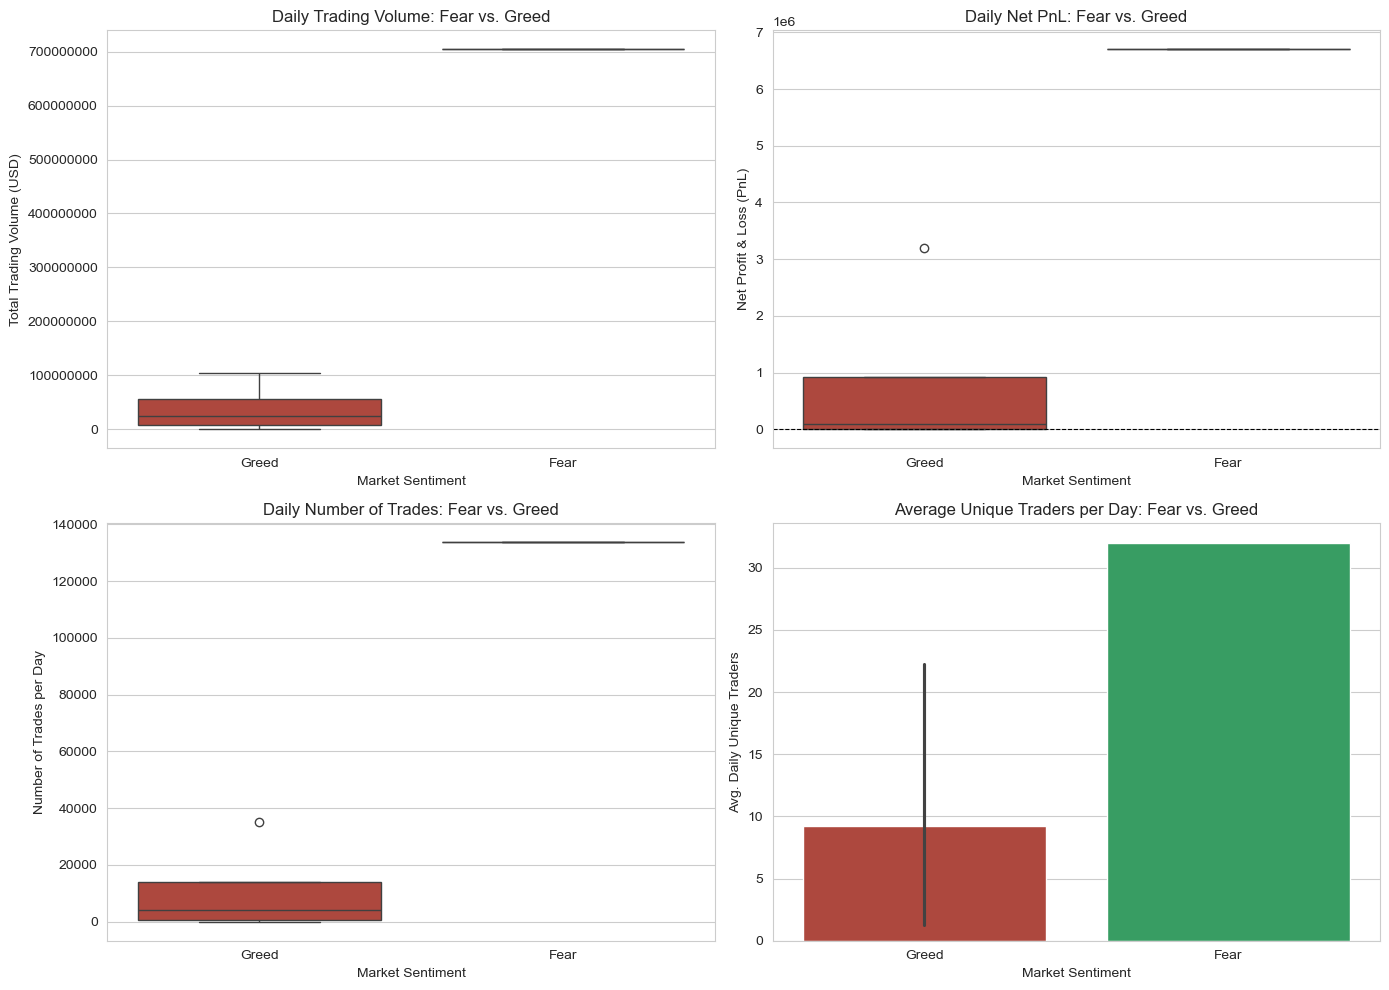

In [45]:
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

sns.set_style("whitegrid")
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.boxplot(data=merged_df, x='classification', y='total_volume', hue='classification', palette=['#c0392b', '#27ae60'], legend=False)
plt.title('Daily Trading Volume: Fear vs. Greed')
plt.xlabel('Market Sentiment')
plt.ylabel('Total Trading Volume (USD)')
plt.ticklabel_format(style='plain', axis='y')

plt.subplot(2, 2, 2)
sns.boxplot(data=merged_df, x='classification', y='net_pnl', hue='classification', palette=['#c0392b', '#27ae60'], legend=False)
plt.title('Daily Net PnL: Fear vs. Greed')
plt.xlabel('Market Sentiment')
plt.ylabel('Net Profit & Loss (PnL)')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

plt.subplot(2, 2, 3)
sns.boxplot(data=merged_df, x='classification', y='trade_count', hue='classification', palette=['#c0392b', '#27ae60'], legend=False)
plt.title('Daily Number of Trades: Fear vs. Greed')
plt.xlabel('Market Sentiment')
plt.ylabel('Number of Trades per Day')

plt.subplot(2, 2, 4)
sns.barplot(data=merged_df, x='classification', y='unique_traders', hue='classification', palette=['#c0392b', '#27ae60'], estimator=np.mean, legend=False)
plt.title('Average Unique Traders per Day: Fear vs. Greed')
plt.xlabel('Market Sentiment')
plt.ylabel('Avg. Daily Unique Traders')

plt.tight_layout()
plt.savefig(f'{output_dir}/sentiment_behavior_summary.png')
plt.show()

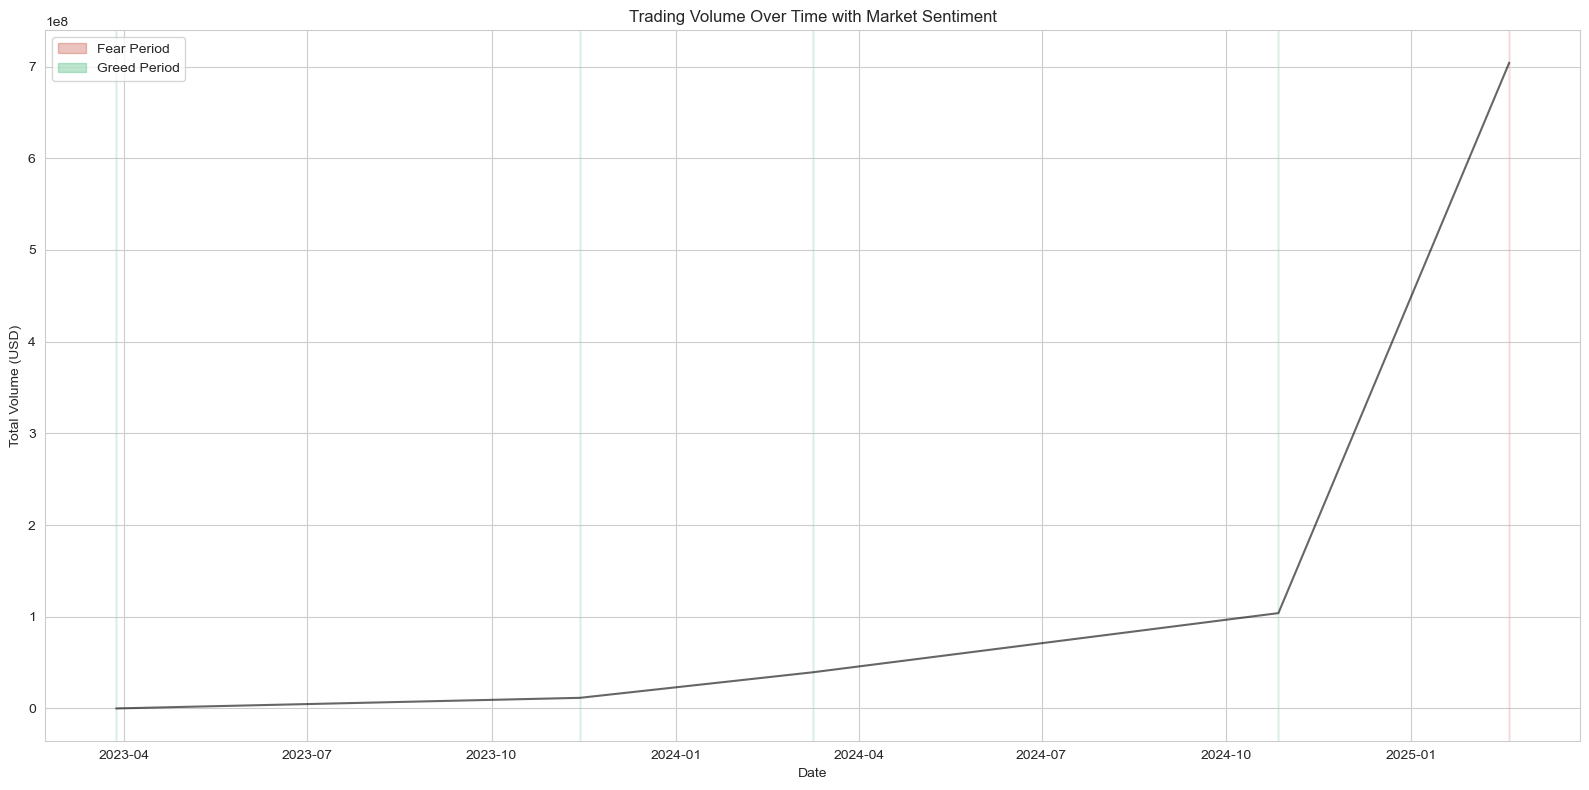

In [46]:
fig, ax1 = plt.subplots(figsize=(16, 8))
ax1.plot(merged_df['date'], merged_df['total_volume'], color='black', alpha=0.6, label='Total Volume')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Volume (USD)')
ax1.set_title('Trading Volume Over Time with Market Sentiment')
ax1.tick_params(axis='y')

for idx, row in merged_df.iterrows():
    color = '#27ae60' if row['classification'] == 'Greed' else '#c0392b'
    ax1.axvspan(row['date'] - pd.Timedelta(days=0.5), row['date'] + pd.Timedelta(days=0.5), facecolor=color, alpha=0.2)

legend_patches = [mpatches.Patch(color='#c0392b', alpha=0.3, label='Fear Period'),
                  mpatches.Patch(color='#27ae60', alpha=0.3, label='Greed Period')]
plt.legend(handles=legend_patches)
plt.tight_layout()
plt.savefig(f'{output_dir}/volume_over_time_with_sentiment.png')
plt.show()